<a href="https://colab.research.google.com/github/alfiannnas/tbc-detection-app/blob/main/UnderSamplingTBC_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TBC Detection using CNN

## Import Library

In [1]:
import shutil
import kagglehub
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


## Import Dataset

In [9]:
# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tuberculosis-tb-chest-xray-dataset


In [12]:
import shutil

# Use the actual path returned by kagglehub
dst_path = "/content/dataset"

shutil.copytree(path, dst_path, dirs_exist_ok=True)

print("Dataset copied to:", dst_path)


Dataset copied to: /content/dataset


## Load Dataset

### Check Dataset

In [13]:
# Check and Count our Dataset
path = '/content/dataset/TB_Chest_Radiography_Database'
counter = 0
dir_names=['Normal', 'Tuberculosis']

for file in (dir_names):
    dir = os.listdir(f"{path}/{file}")

    print(f"Data for {file} is {len(dir)}")

Data for Normal is 3500
Data for Tuberculosis is 700


### Load Metadata

In [14]:
# Load Metadata
df_norm = pd.read_excel('/content/dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('/content/dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [15]:
# Check Sample Data of Normal Metadata
df_norm = df_norm.sample(n=700, random_state=42)

df_norm


,FILE NAME,FORMAT,SIZE,URL
1650,Normal-1651,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
2456,Normal-2457,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
2232,Normal-2233,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
1945,Normal-1946,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
309,Normal-310,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
...,...,...,...,...
3127,Normal-3128,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
744,Normal-745,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
631,Normal-632,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
1557,Normal-1558,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [16]:
# Check Sample Data of Tuberculosis Metadata
df_tb

,FILE NAME,FORMAT,SIZE,URL
0,Tuberculosis-1,PNG,512*512,http://tuberculosis.by/
1,Tuberculosis-2,PNG,512*512,http://tuberculosis.by/
2,Tuberculosis-3,PNG,512*512,http://tuberculosis.by/
3,Tuberculosis-4,PNG,512*512,http://tuberculosis.by/
4,Tuberculosis-5,PNG,512*512,http://tuberculosis.by/
...,...,...,...,...
695,Tuberculosis-696,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
696,Tuberculosis-697,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
697,Tuberculosis-698,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
698,Tuberculosis-699,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...


In [17]:
# Add Label for Every row of metadata ['Tuberculosis']
df_norm['Tuberculosis'] = float(0)
df_tb['Tuberculosis'] = float(1)

# Remove Unused Column
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)


In [18]:
# Merge DF Normal and DF Tuberculosis into 1 Dataframe
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

# Set Label
label = ['Tuberculosis']

In [19]:
# Check Our Result of Dataframe After Merged
df

,FILE NAME,Tuberculosis
0,Tuberculosis-651,1.0
1,Normal-1667,0.0
2,Normal-2447,0.0
3,Tuberculosis-522,1.0
4,Tuberculosis-134,1.0
...,...,...
1395,Normal-2914,0.0
1396,Normal-3273,0.0
1397,Tuberculosis-217,1.0
1398,Tuberculosis-92,1.0


## Split Data

In [20]:
# Create Folder Training, Validation, and Testing

root_path = './'
train_dir = os.path.join(root_path, 'training')
val_dir = os.path.join(root_path, 'validation')
test_dir = os.path.join(root_path, 'testing')

# Create All Necessary Directories

for split in ['training', 'validation', 'testing']:
    for label in ['Normal', 'Tuberculosis']:
        os.makedirs(os.path.join(root_path, split, label), exist_ok=True)

os.makedirs(os.path.join(root_path, 'Images'), exist_ok=True)

In [21]:
# Set Path Directory of Data Folder That Has Been Created Before

IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

In [23]:
# Set Path Directory Source of Dataset

PATH_NORM = os.path.join(path, 'Normal')
PATH_TB = os.path.join(path, 'Tuberculosis')

In [24]:
# Function to Split Data. So the Data from the source its copied into Training, Validation, and Testing Folder

def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'Skipping, Ignore Zero Length!')

  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)


split_data(PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [25]:
# Function to count files in a directory
def count_files(path):
    return len(os.listdir(path))

# --- Normal ---
print("Normal Data Split:")
print(f"Training: {count_files(TRAINING_NORM_DIR)} images")
print(f"Validation: {count_files(VAL_NORM_DIR)} images")
print(f"Testing: {count_files(TESTING_NORM_DIR)} images\n")

# --- Tuberculosis ---
print("Tuberculosis Data Split:")
print(f"Training: {count_files(TRAINING_TB_DIR)} images")
print(f"Validation: {count_files(VAL_TB_DIR)} images")
print(f"Testing: {count_files(TESTING_TB_DIR)} images")


Normal Data Split:
Training: 2800 images
Validation: 350 images
Testing: 350 images

Tuberculosis Data Split:
Training: 560 images
Validation: 70 images
Testing: 70 images


In [26]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):

    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')

    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)

    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(PATH_NORM, PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [27]:
len(os.listdir(IMAGE_DIR))

4200

In [28]:
df

,FILE NAME,Tuberculosis
0,Tuberculosis-651,1.0
1,Normal-1667,0.0
2,Normal-2447,0.0
3,Tuberculosis-522,1.0
4,Tuberculosis-134,1.0
...,...,...
1395,Normal-2914,0.0
1396,Normal-3273,0.0
1397,Tuberculosis-217,1.0
1398,Tuberculosis-92,1.0


In [29]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['FILE NAME'].isin(df_ext)]

    return df_res

In [30]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR, df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [31]:
val_df

,FILE NAME,Tuberculosis
14,Normal-434,0.0
15,Tuberculosis-461,1.0
19,Normal-3350,0.0
29,Normal-1252,0.0
38,Normal-795,0.0
...,...,...
1354,Tuberculosis-29,1.0
1362,Normal-1363,0.0
1372,Tuberculosis-5,1.0
1376,Normal-3283,0.0


In [32]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['FILE NAME'] = train_df['FILE NAME'] + '.png'
val_df['FILE NAME'] = val_df['FILE NAME'] + '.png'
test_df['FILE NAME'] = test_df['FILE NAME'] + '.png'

<ipython-input-32-3c6aeccfd634>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['FILE NAME'] = train_df['FILE NAME'] + '.png'
<ipython-input-32-3c6aeccfd634>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['FILE NAME'] = val_df['FILE NAME'] + '.png'
<ipython-input-32-3c6aeccfd634>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [33]:
# If we create dfs correctly, the sum of rows ahould be 4200
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

1400


In [34]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

In [35]:
train_norm[:5]

['./training/Normal/Normal-2008.png',
 './training/Normal/Normal-2331.png',
 './training/Normal/Normal-2845.png',
 './training/Normal/Normal-3067.png',
 './training/Normal/Normal-2222.png']

Normal


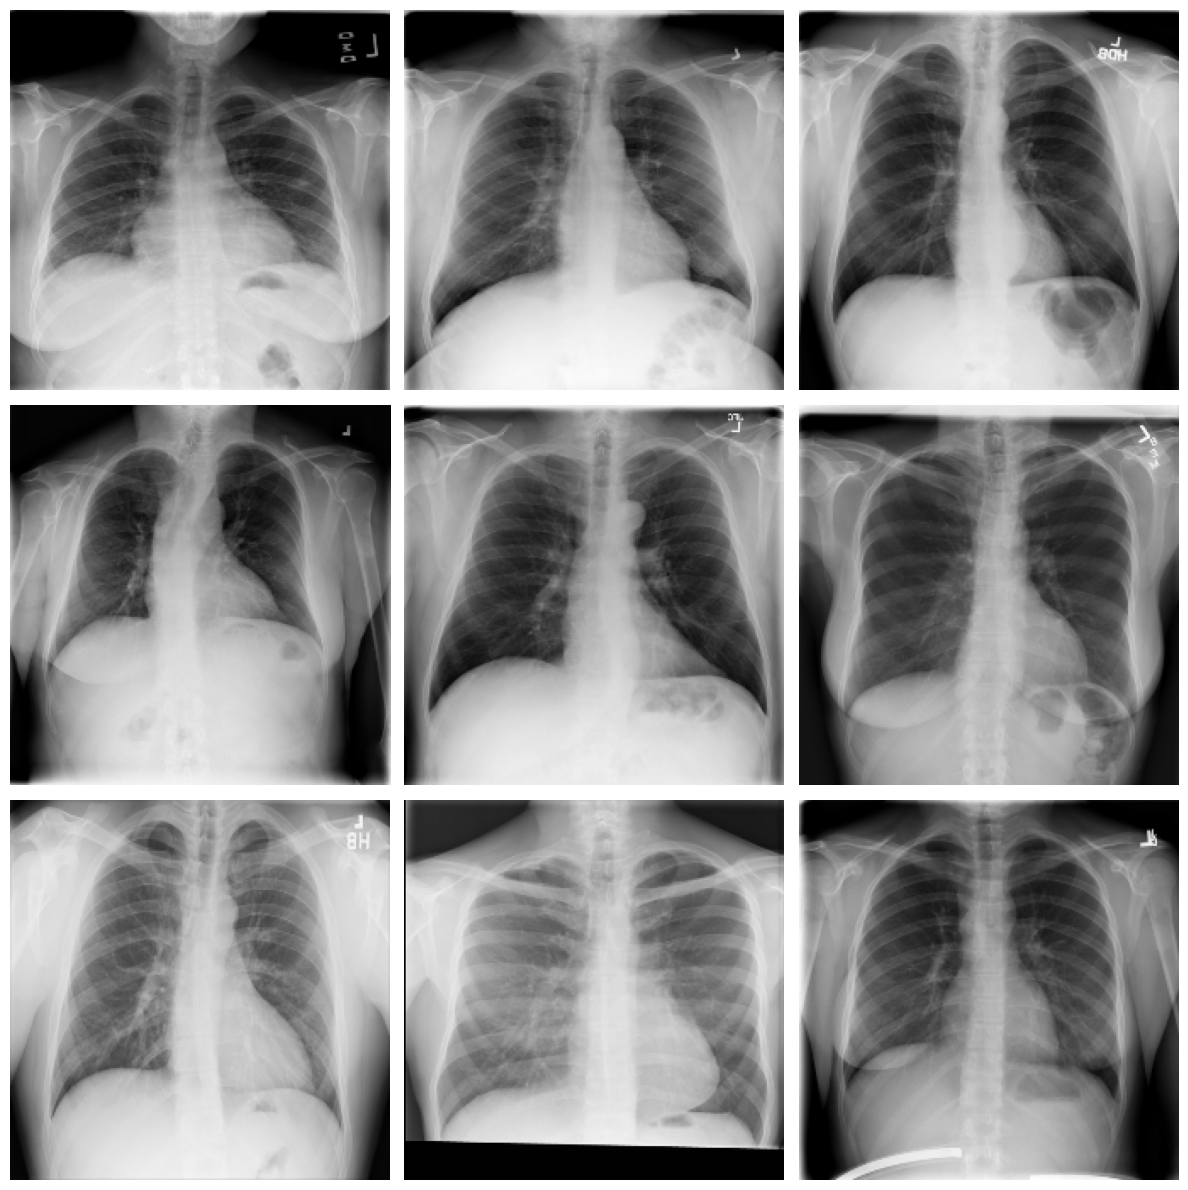

In [36]:

print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [37]:
df

,FILE NAME,Tuberculosis
0,Tuberculosis-651,1.0
1,Normal-1667,0.0
2,Normal-2447,0.0
3,Tuberculosis-522,1.0
4,Tuberculosis-134,1.0
...,...,...
1395,Normal-2914,0.0
1396,Normal-3273,0.0
1397,Tuberculosis-217,1.0
1398,Tuberculosis-92,1.0


## Data Preprocessing

In [38]:
# Params Configuration
x_col = 'FILE NAME'
y_col = 'Tuberculosis'
target_w = 320
target_h = 320
batch_size = 8
shuffle = True
seed = 1

# Data Augmentation
image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    zoom_range=0.1,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Create Train Generator
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed,
    target_size=(target_w, target_h)
)

# Sample Data of Train Generator
images, labels = next(train_generator)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Found 1127 validated image filenames.
Images shape: (8, 320, 320, 3)
Labels shape: (8,)


In [39]:
# Params Configuration

sample_size = 100
batch_size = 8
seed = 1
target_w = 320
target_h = 320

# Getting Sample

raw_train_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=sample_size,
    shuffle=True,
    seed=seed,
    target_size=(target_w, target_h)
)

# Step 2: Ambil 1 batch sample dari training generator
batch = next(raw_train_generator)
data_sample = batch[0]  # hanya ambil data gambarnya

# Step 3: Setup ImageDataGenerator dengan mean/std dari sample
image_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Step 4: Fit mean dan std dari sample training data
image_generator.fit(data_sample)

# Step 5: Buat validation generator
val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
    target_size=(target_w, target_h)
)

# Step 6: Buat test generator
test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
    target_size=(target_w, target_h)
)


Found 1127 validated image filenames.
Found 136 validated image filenames.
Found 137 validated image filenames.


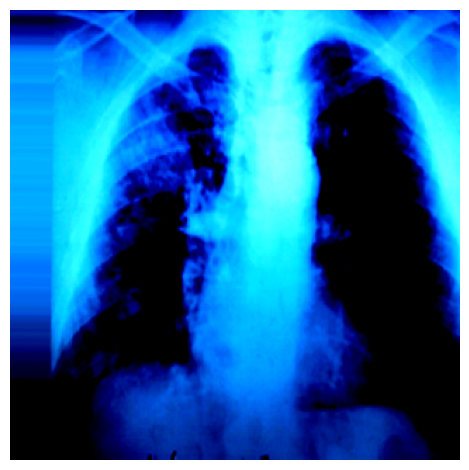

Image shape (320, 320, 3)


In [40]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

In [41]:

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

In [51]:
## create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs = output)
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=["accuracy","AUC"])

### Callback

In [54]:
from tensorflow.keras.callbacks import Callback

class StopOnValAccuracy(Callback):
    def __init__(self, target_acc=0.92):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None:
            print(f"\nValidation accuracy after epoch {epoch+1}: {val_acc:.4f}")
            if val_acc >= self.target_acc:
                print(f"\nReached {self.target_acc*100:.0f}% validation accuracy. Stopping training.")
                self.model.stop_training = True


In [56]:
stop_callback = StopOnValAccuracy(target_acc=0.92)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[stop_callback]
)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - AUC: 0.9675 - accuracy: 0.9123 - loss: 0.2368
Validation accuracy after epoch 1: 0.9779

Reached 92% validation accuracy. Stopping training.
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - AUC: 0.9675 - accuracy: 0.9123 - loss: 0.2368 - val_AUC: 0.9990 - val_accuracy: 0.9779 - val_loss: 0.0898


In [57]:
model.save('model_tbc.h5')  # Simpan model ke file .h5


In [58]:
from keras.models import load_model

model = load_model('model_tbc.h5', compile=False)


In [59]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
from keras.models import load_model
from PIL import Image

# Upload file dari lokal
uploaded = files.upload()

# Load model
model = load_model('model_tbc.h5', compile=False)

# Label kelas (ganti sesuai dengan modelmu)
classes = ['Normal', 'TBC']

# Ambil nama file yang diupload
img_path = list(uploaded.keys())[0]

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=(320, 320))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalisasi jika perlu

# Prediksi
pred = model.predict(img_array)
predicted_class = classes[np.argmax(pred)]

print("Prediksi:", predicted_class)


Saving Tuberculosis-11.png to Tuberculosis-11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediksi: Normal


In [60]:
predicted_vals = model.predict(test_generator, steps=len(test_generator))

y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 719ms/step


In [61]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95        67
         1.0       0.93      0.99      0.96        70

    accuracy                           0.96       137
   macro avg       0.96      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137

Accuracy of the Model: 95.62043795620438 %


In [62]:
# save predictions to csv file

y_labels = ['Normal', 'Tuberculosis']
predictions = [y_labels[k] for k in y_pred]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions})
results.to_csv("predictions.csv",index=False)

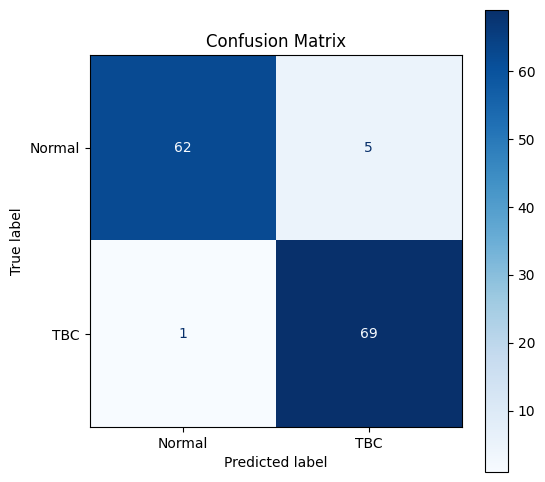

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Misal y_test dan y_pred sudah tersedia
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'TBC'])

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()
